In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sys
import os
import random
import gc
import subprocess
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.style.use('./stylelib/custom.mplstyle')

%reload_ext autoreload
%autoreload 2
import preprocessing
import plotter

---

## 1 Data inspection and loading
### 1.1 Downsample training data
Only 0.5% of the all training records is used for exploratory data analysis

In [3]:
%%time

dir_data = './data'
from_scratch = False

csv_train_raw = os.path.join(dir_data, 'train.csv')
csv_train = os.path.join(dir_data, 'train_sample.csv')
if from_scratch:
    nlines_raw, nlines_reduced = preprocessing.csv_randomized_downsamp(
        csv_in=csv_train_raw, csv_out=csv_train, fraction=0.005
    )

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 16.9 µs


### 1.2 Load data into dataframe
#### (1) Field inspections
For efficiency concerns, we use shell commands instead of pandas operations.

In [4]:
# Quick check of training data fields by calling system shell command
!head -2 ./data/train_sample.csv

ip,app,device,os,channel,click_time,attributed_time,is_attributed
93766,3,1,19,205,2017-11-07 10:28:10,,0


In [5]:
# Quick check of test data fields by calling system shell command
!head -2 ./data/test.csv

click_id,ip,app,device,os,channel,click_time
0,5744,9,1,3,107,2017-11-10 04:00:00


**[CAUTION]** We should be very careful about the use of datetime feature `click_time`. The simple check above indicates the date value of the training and testing data don't overlap. For this reason, we should NOT use raw date or day-of-the-week as a feature when training our model.

**[Notes] Field selections** <br>
Note that from above that training and testing data don't share the same fields. <br>
To prepare data for subsequent processing, we only preserve fields that are common in both training and testing data. One exception is the `is_attributed` field in training data; It is the prediction target and thus needs to be preserved.

In [6]:
# Extract field names from training and testing data
fields_train = preprocessing.csv_list_fields(csv_in=csv_train)
csv_test = os.path.join(dir_data, 'test.csv')
fields_test = preprocessing.csv_list_fields(csv_in=csv_test)

# Extract fields shared by both training and testing data
fields_use = list(set(fields_train) & (set(fields_test)))
print('Data fields shared by both training and testing data:\n', fields_use)

Data fields shared by both training and testing data:
 ['os', 'click_time', 'ip', 'channel', 'device', 'app']


#### (2) Load into dataframe

In [7]:
# Load randomly sampled data subset into pandas dataframe,
# and sort by click time (and reset index)
df = pd.read_csv(
    csv_train, usecols=fields_use + ['is_attributed'],
    parse_dates=['click_time']
).sort_values(by='click_time').reset_index(drop=True)

# Convert click time from UTC to local time
df['click_time'] = (
    pd.DatetimeIndex(df['click_time']).tz_localize('utc')
    .tz_convert('Asia/Shanghai')
)

In [8]:
# Inspect first few lines
df.head(3)

,ip,app,device,os,channel,click_time,is_attributed
0,143257,3,1,15,379,2017-11-06 23:41:21+08:00,0
1,186555,3,1,13,379,2017-11-06 23:54:57+08:00,0
2,119289,3,1,13,379,2017-11-06 23:57:20+08:00,0


---
## 2. Exploratory data analysis
### 2.1 Do we have imbalanced classes?

In [9]:
# Inspect data size
nclick_total =len(df)
percentage_pos = (df['is_attributed'].sum()) / nclick_total * 100
print('Percentage of positive target = {:.3f}%'.format(percentage_pos))

Percentage of positive target = 0.248%


**[CAUTION] Class imbalance**<br>
Given that only ~0.25% of the records has positive target values (`df['is_attributed'] == 1`), we have **an extreme case of class imbalance** at hand.

### 2.2 Convert datetime variable to usable form
To convert datetime to a more usable form, we extract hour-of-the-day information

In [10]:
# Extract hour of the day
df['click_hour'] = df['click_time'].dt.hour

# Drop raw `click_time`
df.drop(columns=['click_time'], inplace=True)

In [11]:
df.head(3)

,ip,app,device,os,channel,is_attributed,click_hour
0,143257,3,1,15,379,0,23
1,186555,3,1,13,379,0,23
2,119289,3,1,13,379,0,23


### 2.3 Train-test split, and set aside testing data

In [12]:
# Split the original dataframe into in-sample training and testing sets
# Because stratified sampling is the default option of sklearn, it is not
# explicitly set
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Double check class ratios after train-test split
print(
    'Training data (pos%):',
    100 * df_train['is_attributed'].sum() / len(df_train)
)
print(
    'Testing data (pos%):',
    100 * df_test['is_attributed'].sum() / len(df_test)
)

Training data (pos%): 0.24962799171151626
Testing data (pos%): 0.2449919958464933


### 2.4 Inspect variable distributions of training data

In [13]:
# Count the amount of unique values
df_counts = pd.DataFrame()
df_counts['n_unique'] = df_train.nunique()
df_counts['n_unique (%)'] = 100 * df_counts['n_unique'] / len(df_train)
df_counts.T

,ip,app,device,os,channel,is_attributed,click_hour
n_unique,87459.000000,309.000000,503.000000,204.000000,174.000000,2.000000,24.000000
n_unique (%),6.757108,0.023873,0.038862,0.015761,0.013443,0.000155,0.001854


**[TAKE AWAY]**<br>
* Without exception, the total number of unique values for each of these variables is markedly smaller than the total number of clicks. This indicates that many-to-one mapping is typical between clicks and these variables. This makes sense because a single user can generate multiple clicks.
* The amount of distinct values in categorical features is very high. We will need to make major efforts in feature engineering.

In [14]:
feature_list = [col for col in df_train.columns if col != 'is_attributed']
df_train_imputed, df_test_imputed = preprocessing.df_rarelabel_imputer(
    df_train, df_test, cols=feature_list,
    thresh_percentage=0.2, replace_with=1e10
)

In [15]:
df_train_imputed.head()

,ip,app,device,os,channel,is_attributed,click_hour
545636,10000000000,21,2,9,128,0,22
988565,10000000000,12,1,13,178,0,17
770783,10000000000,12,1,17,409,0,10
386256,10000000000,14,1,13,489,0,17
1371006,10000000000,23,1,17,153,0,9


### 2.5 Apply target-guided encoding to categorical features

In [16]:
df_train, df_test = preprocessing.df_label2num_encoding(
    df_train, df_test, cols=feature_list
)
df_train_imputed, df_test_imputed = preprocessing.df_label2num_encoding(
    df_train_imputed, df_test_imputed, cols=feature_list
)

### 2.6 Check dataframes after encoding

Note that mapping used for encoding is generated with training data and then propagated to testing data. 
Because there are non-overlap variables between training and testing data, and encoded testing data are going to have missing values. Let's have a look:

In [17]:
# Check presence of missing value after encoding
df_nulls = pd.DataFrame()
df_nulls['nan_train(%)'] = 100 * (df_train.isnull().sum() / len(df_train))
df_nulls['nan_test(%)'] = 100 * (df_test.isnull().sum() / len(df_test))
df_nulls.T

,is_attributed,risk_ip,count_ip,risk_app,count_app,risk_device,count_device,risk_os,count_os,risk_channel,count_channel,risk_click_hour,count_click_hour
nan_train(%),0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.0
nan_test(%),0.0,1.869979,1.869979,0.003065,0.003065,0.020731,0.020731,0.002524,0.002524,0.00018,0.00018,0.0,0.0


As expected, for `*_woe` variables, the testing data have missing values that requires clean up. We will test a number of approaches later, and use simply dropping the value as a baseline for comparisons.

### 2.7 Check Pearson's correlation coefficient

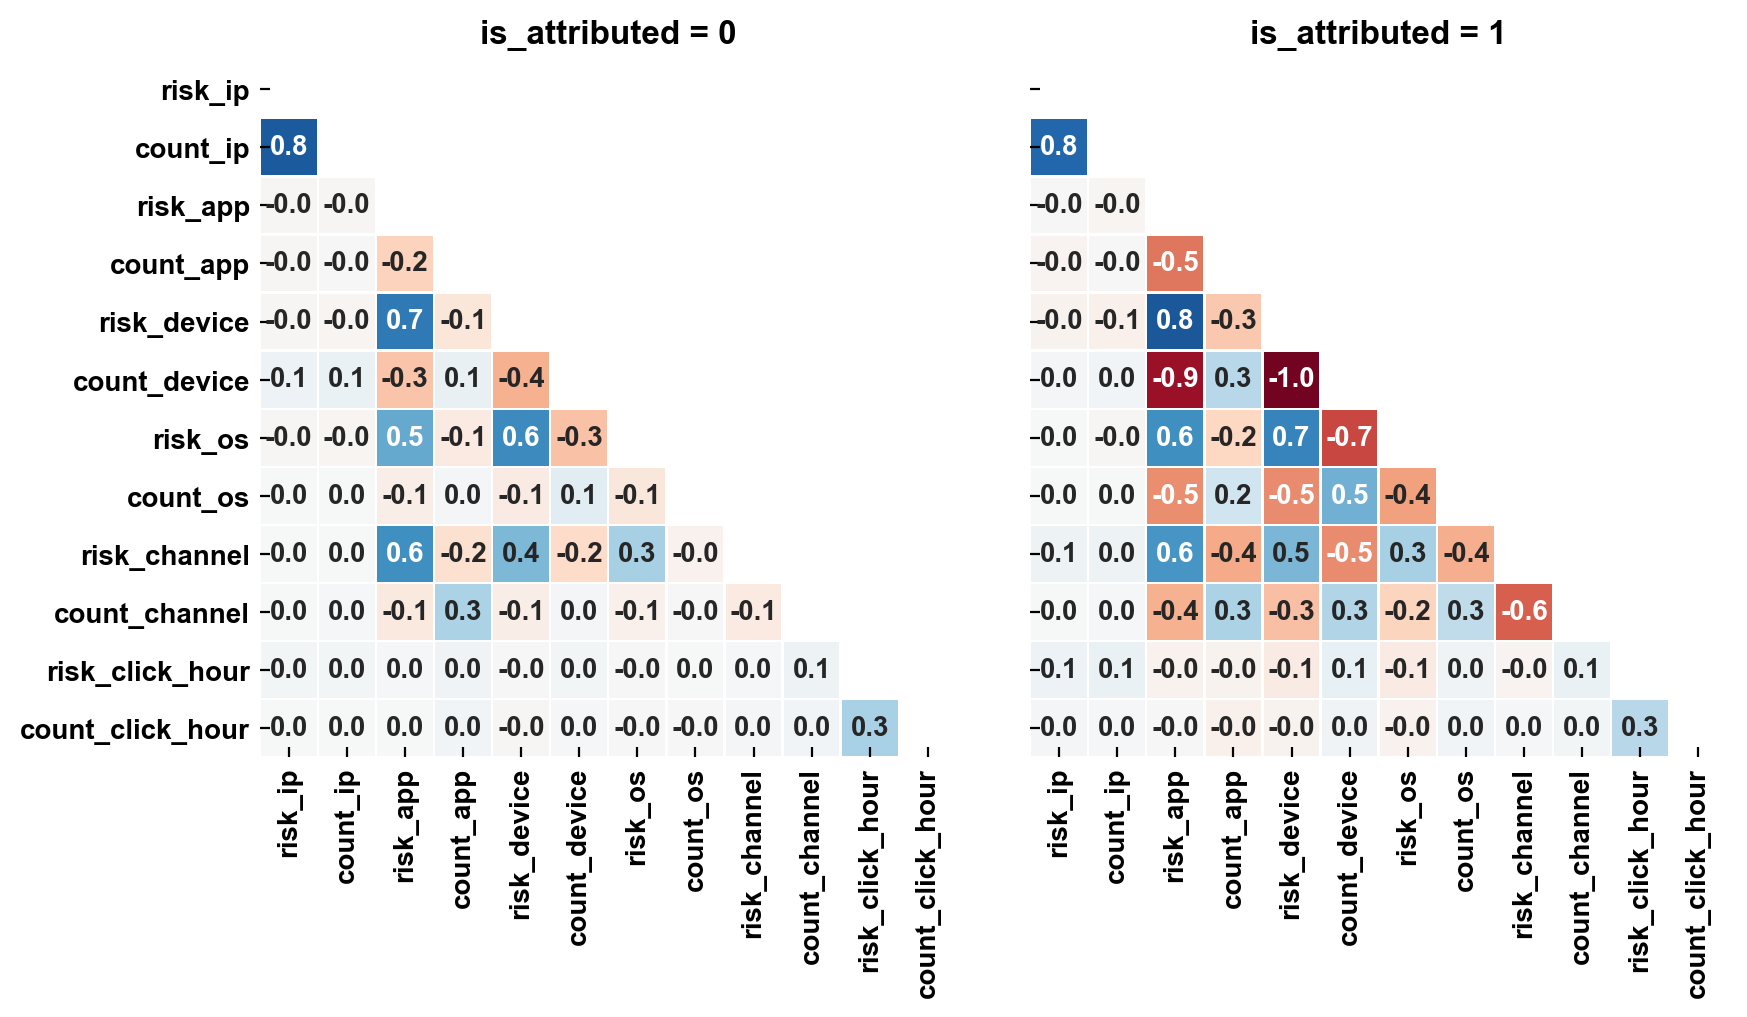

In [18]:
# Exclude target variable from correlation calculation
plotter.plot_corrmat(df_train)

---
## 3. Machine learning

In [60]:
def df_2_Xy(impute=True):
    target_col = 'is_attributed'
    cols = [x for x in df_train.columns if x != target_col]
    #cols = [x for x in df_train.columns if x != target_col and 'count' not in x]
    #cols = [x for x in df_train.columns if x != target_col and 'risk' not in x]
    if impute:
        df_train_imputed.fillna(0.0, inplace=True)
        df_test_imputed.fillna(0.0, inplace=True)
        X_train, y_train = (
            df_train_imputed[cols], df_train_imputed[target_col]
        )
        X_test, y_test = (
            df_test_imputed[cols], df_test_imputed[target_col]
        )
    else:
        df_train.fillna(0.0, inplace=True)
        df_test.fillna(0.0, inplace=True)
        X_train, y_train = (df_train[cols], df_train[target_col])
        X_test, y_test = (df_test[cols], df_test[target_col])
    return (X_train, y_train, X_test, y_test)

In [61]:
X_train, y_train, X_test, y_test = df_2_Xy(impute=False)

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (cross_val_score, RandomizedSearchCV)

In [63]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [64]:
lgc = LogisticRegression(class_weight='balanced')
lgc.fit(X_train, y_train)
y_pred = lgc.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(auc)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.9019018649018017


In [65]:
model = DecisionTreeClassifier(class_weight='balanced', max_depth=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [66]:
y_pred2 = model.predict(X_train)
auc = roc_auc_score(y_train, y_pred2)
print(auc)

0.9059152861554185


In [67]:
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.8982832829100477


In [70]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(
    'balanced', y_train.unique(), y_train
)
class_weight

array([  0.50125126, 200.29805014])

In [68]:
model = RandomForestClassifier(class_weight='balanced', n_estimators=50, max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(auc)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

0.9041089455573448


In [ ]:
import xgboost as xgb
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

# Create the parameter dictionary for each tree: params
params = {"objective":"reg:linear", "max_depth":4}

# Perform cross-validation with early stopping: cv_results
cv_results = xgb.cv(
    dtrain=housing_dmatrix, params=params, metrics='rmse',
    early_stopping_rounds=10, num_boost_round=50,
    seed=123
)

# Print cv_results
print(cv_results)

In [71]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
    class_weight=class_weight, max_depth=3, n_estimators=50, learning_rate=0.05
).fit(X_train, y_train)
y_pred = gbm.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.5327365329539133


/Users/shandou/anaconda/envs/mlnd/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [59]:
# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense

# create model
model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, epochs=1, batch_size=128)
y_pred = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred)
print(auc)

Epoch 1/1
1294326/1294326 [==============================] - 26s 20us/step - loss: 0.0227 - acc: 0.9957


0.8672992748374709
